# Are You Really Taking Care of Overfitting?

Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import catboost
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['axes.axisbelow'] = True

Download data from Kaggle

In [3]:
! kaggle datasets download -d mlg-ulb/creditcardfraud

Load dataset

In [4]:
df = pd.read_csv('mushrooms.csv').sample(frac = 1, random_state = 0)

Do train/test split (33%, 67% respectively)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('class', axis = 1), 
    (df['class'] == 'p') * 1, 
    test_size = .67, 
    stratify = df['class'],
    random_state = 0
)

Dump row index among x columns

In [6]:
x_train = x_train.reset_index(drop = True).reset_index(drop = False)
x_test = x_test.reset_index(drop = True).reset_index(drop = False)
x_train.columns = ['ROW_INDEX'] + list(x_train.columns[1:])
x_test.columns = ['ROW_INDEX'] + list(x_test.columns[1:])
print('x_train.shape:', x_train.shape)
print('x_test.shape: ', x_test.shape)

x_train.shape: (2680, 23)
x_test.shape:  (5444, 23)


Set hyperparameters and categorical features.

These hyperparameters have been found with the purpose of overfitting as much as possible, that is for demonstration purposes.

Of course, if you used Catboost's default hyperparameters, you will have a far better model.

However, this was done intentionally to exaggerate the real life situation in which you overfit despite early-stopping.

In [7]:
hyperparams = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'bagging_temperature': 373.03746280450906,
    'border_count': 6646.0,
    'l2_leaf_reg': 2161.2073213839294,
    'learning_rate': 0.752111526018494,
    'max_depth': 7.0,
    'min_data_in_leaf': 681.0,
    'model_size_reg': 6.496948932044811,
    'random_strength': 2191.2170647992484,
    'rsm': 0.9584220297555596,
    'class_weights': [1, 881.7037892757262]
}

cat_features = list(range(1, len(x_train.columns)))

Run CatBoost

In [8]:
clf = catboost.CatBoostClassifier(**hyperparams)
clf_fitted = clf.fit(X = x_train, y = y_train,
                     eval_set = (x_test, y_test),
                     cat_features = cat_features,
                     early_stopping_rounds = 10)

0:	learn: 0.3239845	test: 0.4526990	best: 0.4526990 (0)	total: 55ms	remaining: 5.45s
1:	learn: 0.1155477	test: 0.1676479	best: 0.1676479 (1)	total: 57.8ms	remaining: 2.83s
2:	learn: 0.1064180	test: 0.1567212	best: 0.1567212 (2)	total: 66.5ms	remaining: 2.15s
3:	learn: 0.0624951	test: 0.0919802	best: 0.0919802 (3)	total: 71.2ms	remaining: 1.71s
4:	learn: 0.0512691	test: 0.0751309	best: 0.0751309 (4)	total: 74.5ms	remaining: 1.42s
5:	learn: 0.0436477	test: 0.0636197	best: 0.0636197 (5)	total: 79.5ms	remaining: 1.25s
6:	learn: 0.0381683	test: 0.0553029	best: 0.0553029 (6)	total: 82.8ms	remaining: 1.1s
7:	learn: 0.0310562	test: 0.0444546	best: 0.0444546 (7)	total: 85.7ms	remaining: 985ms
8:	learn: 0.0298358	test: 0.0428165	best: 0.0428165 (8)	total: 93.6ms	remaining: 946ms
9:	learn: 0.0284332	test: 0.0418612	best: 0.0418612 (9)	total: 98.5ms	remaining: 887ms
10:	learn: 0.0263148	test: 0.0384637	best: 0.0384637 (10)	total: 104ms	remaining: 842ms
11:	learn: 0.0232095	test: 0.0334741	best: 0.

Calculate probabilities and performance (average precision) on training and test

In [9]:
proba_train = clf_fitted.predict_proba(x_train)[:,1]
proba_test = clf_fitted.predict_proba(x_test)[:,1]
ap_train = average_precision_score(y_train, proba_train)
ap_test = average_precision_score(y_test, proba_test)

In [10]:
print(ap_train, ap_test)

0.9377634045723214 0.7868095131406349


Store performance on train and test at each iteration

In [11]:
ap_train_iter, ap_test_iter = [], []
for iteration in range(hyperparams['iterations']):
    clf = catboost.CatBoostClassifier(**hyperparams)
    clf.set_params(iterations = 1)
    clf_fitted = clf.fit(X = x_train, y = y_train,
                         eval_set = (x_test, y_test),
                         cat_features = cat_features,
                         early_stopping_rounds = 10, 
                         init_model = clf_fitted if iteration > 0 else None,
                         silent = True)
    proba_train = clf_fitted.predict_proba(x_train)[:,1]
    proba_test = clf_fitted.predict_proba(x_test)[:,1]
    ap_train = average_precision_score(y_train, proba_train)
    ap_test = average_precision_score(y_test, proba_test)
    ap_train_iter.append(ap_train)
    ap_test_iter.append(ap_test)

Plot performance on training and test set at each iteration

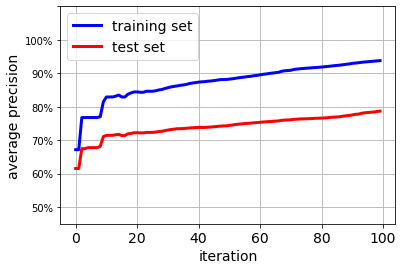

In [12]:
plt.plot(range(len(ap_train_iter)), ap_train_iter, label = 'training set', lw = 3, color = 'blue')
plt.plot(range(len(ap_test_iter)), ap_test_iter, label = 'test set', lw = 3, color = 'red')
plt.ylim(.45, 1.05)
plt.ylabel('average precision', fontsize = 14)
plt.xlabel('iteration', fontsize = 14)
plt.yticks(np.arange(.5, 1.1, .1), [('{}'.format(number) + '%') for number in range(50, 110, 10)])
plt.xticks(fontsize = 14)
plt.grid()
plt.legend(fontsize = 14, loc = 'upper left');

Show feature importances

In [13]:
pd.Series(clf.feature_importances_, index = clf.feature_names_).sort_values(ascending = False).apply(lambda number: str(round(number,2)) + '%').head(8)

ROW_INDEX                   86.92%
gill-size                    8.61%
stalk-shape                  1.64%
stalk-surface-below-ring     1.15%
bruises                      0.62%
gill-spacing                 0.61%
cap-surface                  0.29%
gill-attachment              0.16%
dtype: object